# <center> Milestone 4: Improvements in Machine Learning Life-cycle </center>

### <center> Authors: Albina Cako & Joshua Dalphy </center>

# Table of Contents

* [1. Getting Started](#1)
* [2. Data Transformation](#2)
 * [2.1) Stemming the Dataset](#2.1)
 * [2.2) Removing Numerical Values](#2.2)
* [3. Feature Extraction](#3)
* [4. Modelling](#4)
 * [4.1) Logistic Regression Model](#4.1)
   * [4.1.1) Baseline Model](#4.1.1)
   * [4.1.2) Hyperparameter Tuning](#4.1.2)
* [5. Feature Selection](#5)
 * [5.1) Univariate Selection](#5.1)
 * [5.2) Decision Tree Feature Importance ](#5.2)
 * [5.3) PCA](#5.3)

# 1. Getting Started<a class="anchor" id="1"></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import model_evaluation_utils as meu

# Set print options
np.set_printoptions(precision=2, linewidth=80)

# Load the cleaned preprocessed dataset
dataset = pd.read_csv('Movie_Reviews_12p5k_Clean.csv')

# Remove extra column
dataset = dataset.drop(columns=['Unnamed: 0'])

# replace positive with 1 and negative with 0
dataset.Sentiments = dataset.Sentiments.replace('positive',1)
dataset.Sentiments = dataset.Sentiments.replace('negative',0)

dataset = shuffle(dataset)

# Retrieve the reviews
dataset.head(3)

,Reviews,Sentiments
13484,film pretty awful thing stop give rating 1 fac...,0
15487,give 3 star beautiful picture africa rest well...,0
5291,feel great joy see film not master piece convi...,1


In [2]:
#dataset = dataset[:7000]
# Retrieve the reviews
#dataset.head(3)
dataset.shape

(25000, 2)

In [3]:
# Create a reivew and sentiment array
reviews = np.array(dataset['Reviews'])
sentiment = np.array(dataset['Sentiments'])

# Split the reviews into testing and training 70/30
index = round(0.7*len(reviews))

train_reviews = reviews[:index]
test_reviews  = reviews[index:]

train_sentiments = sentiment[:index]
test_sentiments  = sentiment[index:]

In [4]:
print("train_reviews shape", train_reviews.shape)
print("test_reviews shape", test_reviews.shape)

train_reviews shape (17500,)
test_reviews shape (7500,)


# 2. Data Transformation<a class="anchor" id="2"></a>

## 2.1) Stemming the Dataset<a class="anchor" id="2.1"></a>

In [5]:
#import nltk
#nltk.download()

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
porter = PorterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [6]:
# Apply the stemming function on train_reviews
stem_train_reviews = [None]*len(train_reviews)
idx = 0
for sentence in train_reviews:
    stem_train_reviews[idx] = stemSentence(sentence)
    idx = idx + 1   

# Apply the stemming function on test_reviews
stem_test_reviews = [None]*len(test_reviews)
idx = 0
for sentence in test_reviews:
    stem_test_reviews[idx] = stemSentence(sentence)
    idx = idx + 1  

    
train_reviews = stem_train_reviews  
test_reviews  = stem_test_reviews 

In [7]:
# Get the length of the training set
len(train_reviews)

17500

## 2.2) Removing Numerical Values<a class="anchor" id="2.2"></a>

In [8]:
# Define a function to remove digits from a sentence
import re
def remove_digits(text):
    text = re.sub(r'[0-9]+', '', text)
    #text = re.sub('[^a-zA-Z\s]', '', text)
    return text

In [9]:
# Apply the function to train_reviews
remove_digits_train = []
for doc in train_reviews:
    doc = remove_digits(doc)
    remove_digits_train.append(doc)

# Apply the function to test_reviews
remove_digits_test = []
for doc in test_reviews:
    doc = remove_digits(doc)
    remove_digits_test.append(doc)

    
train_reviews = remove_digits_train
test_reviews = remove_digits_test

# 3. Feature Extraction<a class="anchor" id="3"></a>

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [11]:
# build TFIDF features on train reviews
BOW_tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,1),
                     sublinear_tf=True)
BOW_tv_train_features = BOW_tv.fit_transform(train_reviews)

# transform test reviews into features
BOW_tv_test_features = BOW_tv.transform(test_reviews)

In [12]:
print('TFIDF model:> Train features shape:', BOW_tv_train_features.shape, ' Test features shape:', BOW_tv_test_features.shape)

TFIDF model:> Train features shape: (17500, 45045)  Test features shape: (7500, 45045)


In [13]:
# Visualize some of the features
bow_tv_feature_names = BOW_tv.get_feature_names()

BOW_tv_matrix = BOW_tv_train_features.toarray()
bow_tv_df = pd.DataFrame(BOW_tv_matrix, columns=bow_tv_feature_names)
bow_tv_df.iloc[0:3,2000:2010]

,arthor,arthous,arthrit,arthriti,arthropod,arthur,arthurian,arthuriophil,arti,artic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Modelling<a class="anchor" id="4"></a>

## 4.1) Logistic Regression Model<a class="anchor" id="4.1"></a>

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

### 4.1.1) Baseline Model<a class="anchor" id="4.1.1"></a>

In [15]:
%%time
#lr_bow_tfidf = LogisticRegression(penalty='l2', max_iter=200, C=1)
lr_bow_tfidf = LogisticRegression(max_iter=200)
# Logistic Regression model on BOW-TF-IDF features
lr_bow_tfidf_predictions = meu.train_predict_model(classifier=lr_bow_tfidf, 
                                             train_features=BOW_tv_train_features, train_labels=train_sentiments,
                                             test_features=BOW_tv_test_features, test_labels=test_sentiments)

Wall time: 988 ms


In [16]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_tfidf_predictions,
                                      classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.8837
Precision: 0.8841
Recall: 0.8837
F1 Score: 0.8837

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.87      0.90      0.88      3730
           0       0.90      0.87      0.88      3770

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       3349   381
        0        491  3279


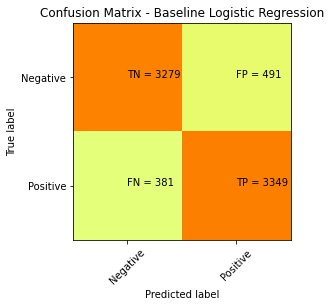

In [17]:
from sklearn.metrics import confusion_matrix,auc
import matplotlib.pyplot as plt

cm = confusion_matrix(test_sentiments, lr_bow_tfidf_predictions)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Baseline Logistic Regression')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



No Skill: ROC AUC=0.500
Logistic Regression: ROC AUC=0.955


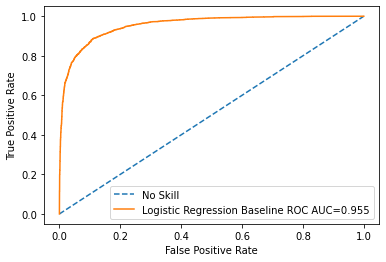

In [18]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_sentiments))]
# predict probabilities
lr_probs = lr_bow_tfidf.predict_proba(BOW_tv_test_features)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(test_sentiments, ns_probs)
lr_auc = roc_auc_score(test_sentiments, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_sentiments, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_sentiments, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, label='Logistic Regression Baseline ROC AUC=%.3f' % (lr_auc))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

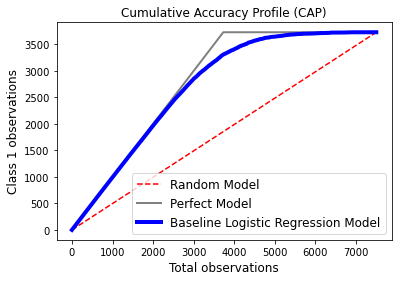

In [19]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
#plt.figure(figsize = (20, 12))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_bow_tfidf.predict_proba(BOW_tv_test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'Baseline Logistic Regression Model', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)

In [20]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Baseline Logistic Regression Model: {}".format(aR / aP))

Accuracy Rate for Baseline Logistic Regression Model: 0.9106888729279411


Percentage: 88.928%


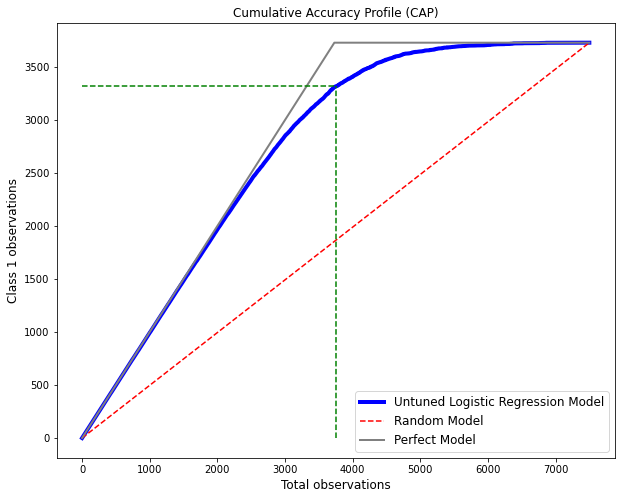

In [21]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'Untuned Logistic Regression Model', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

88.20% is showing that we have a very good model. It does not show overfitting

### 4.1.2) Hyperparameter Tuning<a class="anchor" id="4.1.2"></a>

In [22]:
from sklearn.model_selection import GridSearchCV

penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid = GridSearchCV(estimator=lr_bow_tfidf,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    verbose=1,
                    n_jobs=-1)
grid_result = grid.fit(BOW_tv_train_features, train_sentiments)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

#lr_bow_tfidf_tuned = grid.fit(BOW_tv_train_features, train_sentiments)
#print('Best Score: ', lr_bow_tfidf_tuned.best_score_)
#print('Best Params: ', lr_bow_tfidf_tuned.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 34.5min finished


Best Score:  0.9530309740392667
Best Params:  {'C': 10, 'class_weight': {1: 0.7, 0: 0.3}, 'penalty': 'l2', 'solver': 'saga'}


In [23]:
# Create the tuned model
lr_bow_tfidf_tuned = LogisticRegression(penalty = 'l2',C = 100,class_weight={1: 0.7, 0: 0.3}, solver= 'liblinear', max_iter=200)

# Logistic Regression model on BOW-TF-IDF features
lr_bow_tfidf_predictions_tuned = meu.train_predict_model(classifier=lr_bow_tfidf_tuned, 
                                             train_features=BOW_tv_train_features, train_labels=train_sentiments,
                                             test_features=BOW_tv_test_features, test_labels=test_sentiments)


In [24]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_tfidf_predictions_tuned,
                                      classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.8716
Precision: 0.8735
Recall: 0.8716
F1 Score: 0.8715

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.85      0.91      0.88      3730
           0       0.90      0.84      0.87      3770

    accuracy                           0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.87      0.87      0.87      7500


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       3382   348
        0        615  3155


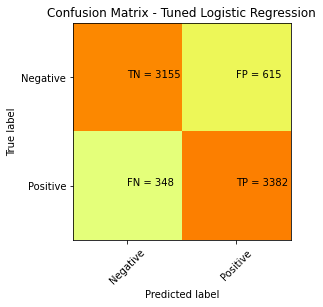

In [25]:
# Display confusion matrix for hypertuned Logistic Regression
cm = confusion_matrix(test_sentiments,lr_bow_tfidf_predictions_tuned)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Tuned Logistic Regression')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


In [26]:
# generate a no skill prediction (majority class)
ns_probs_tuned = [0 for _ in range(len(test_sentiments))]
# predict probabilities
lr_probs_tuned = lr_bow_tfidf_tuned.predict_proba(BOW_tv_test_features)
# keep probabilities for the positive outcome only
lr_probs_tuned = lr_probs_tuned[:, 1]
# calculate scores
ns_auc_tuned = roc_auc_score(test_sentiments, ns_probs_tuned)
lr_auc_tuned = roc_auc_score(test_sentiments, lr_probs_tuned)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc_tuned))
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc_tuned))

No Skill: ROC AUC=0.500
Logistic Regression: ROC AUC=0.949


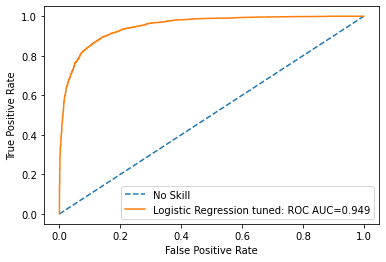

In [27]:
# calculate roc curves
ns_fpr_tuned, ns_tpr_tuned, _ = roc_curve(test_sentiments, ns_probs_tuned)
lr_fpr_tuned, lr_tpr_tuned, _ = roc_curve(test_sentiments, lr_probs_tuned)
# plot the roc curve for the model
pyplot.plot(ns_fpr_tuned, ns_tpr_tuned, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_tuned, lr_tpr_tuned, label='Logistic Regression tuned: ROC AUC=%.3f' % (lr_auc_tuned))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

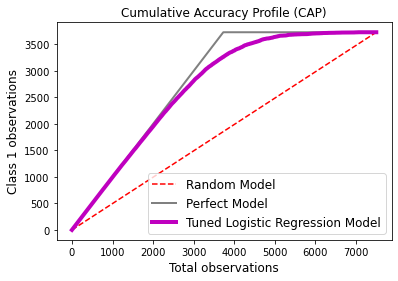

In [28]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
#plt.figure(figsize = (20, 12))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_bow_tfidf_tuned.predict_proba(BOW_tv_test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned Logistic Regression Model', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)

In [29]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Tuned Logistic Regression Model: {}".format(aR / aP))

Accuracy Rate for Tuned Logistic Regression Model: 0.8981452272420193


Percentage: 87.775%


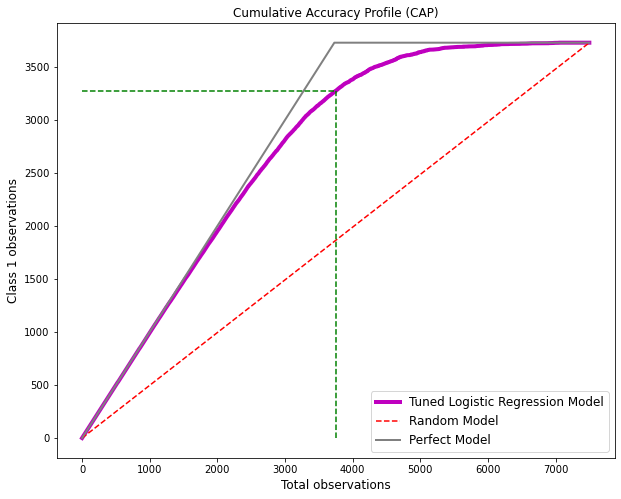

In [30]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned Logistic Regression Model', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

### 4.1.3) Comparison of Results<a class="anchor" id="4.1.3"></a>

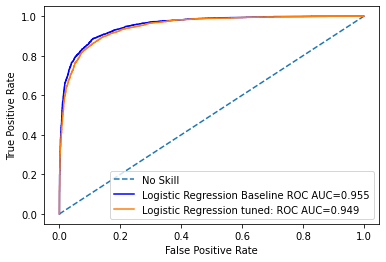

In [31]:
# plot the roc curve for the model
pyplot.plot(ns_fpr_tuned, ns_tpr_tuned, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, label='Logistic Regression Baseline ROC AUC=%.3f' % (lr_auc),color = 'b')
pyplot.plot(lr_fpr_tuned, lr_tpr_tuned, label='Logistic Regression tuned: ROC AUC=%.3f' % (lr_auc_tuned))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# 6. Feature Selection<a class="anchor" id="6"></a>

## 6.1 Univariate Selection<a class="anchor" id="6.1"></a>

In [32]:
# Feature Selection with Univariate Statistical Tests with k = 50
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# feature extraction
test = SelectKBest(score_func=f_classif, k=50)
fit = test.fit(BOW_tv_train_features.toarray(), train_sentiments)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(BOW_tv_train_features.toarray());
# summarize selected features
print(features[0:50,:])

[0.108 0.027 0.995 ... 1.005 1.005 1.005]
[[0.077 0.    0.    ... 0.    0.    0.065]
 [0.    0.    0.    ... 0.    0.061 0.056]
 [0.    0.    0.    ... 0.    0.    0.   ]
 ...
 [0.026 0.    0.    ... 0.03  0.04  0.022]
 [0.042 0.072 0.    ... 0.    0.065 0.061]
 [0.    0.    0.    ... 0.052 0.    0.039]]


In [33]:
# fit.scores_ contains the score of all the features in the training set. In this code block we determine the column 
# number associated to the top k features obtained from the univariate feature selection test

# Save the scores to a variable named score and set the number of features desired (k)
k = 50
score = fit.scores_

# Retrieve the indices associated to the k highest scoring 
indices = score.argsort()[::-1][:k]
# Convert the test features from a sparse matrix to an array
test_features = BOW_tv_test_features.toarray()
# Retrieve the appropriate features from the testing dataset
test_features = test_features[:,indices]

### Tuned Logistic Regression Revisited

In [34]:
# Define the tuned logistic regression model
lr_uni_tuned = LogisticRegression(penalty = 'l2',C = 100,class_weight={1: 0.7, 0: 0.3}, solver= 'liblinear', max_iter=1000)
lr_uni_tuned.fit(features, train_sentiments)
# Predict y_test values
lr_uni_tuned_preds = lr_uni_tuned.predict(test_features) 

In [35]:
# Retrieve the metrics for the model
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_uni_tuned_preds, classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.5263
Precision: 0.527
Recall: 0.5263
F1 Score: 0.5245

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.52      0.59      0.55      3730
           0       0.53      0.46      0.50      3770

    accuracy                           0.53      7500
   macro avg       0.53      0.53      0.52      7500
weighted avg       0.53      0.53      0.52      7500


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       2194  1536
        0       2017  1753


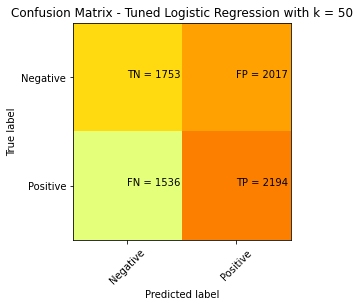

In [36]:
from sklearn.metrics import confusion_matrix,auc
import matplotlib.pyplot as plt

cm = confusion_matrix(test_sentiments, lr_uni_tuned_preds)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Tuned Logistic Regression with k = 50')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.521


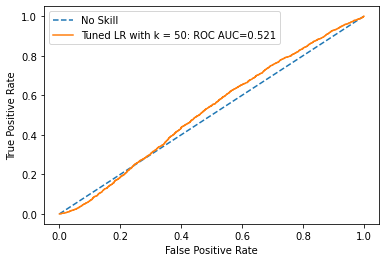

In [37]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_sentiments))]
# predict probabilities
lr_probs = lr_uni_tuned.predict_proba(test_features)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(test_sentiments, ns_probs)
lr_auc = roc_auc_score(test_sentiments, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_sentiments, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_sentiments, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, label='Tuned LR with k = 50: ROC AUC=%.3f' % (lr_auc))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

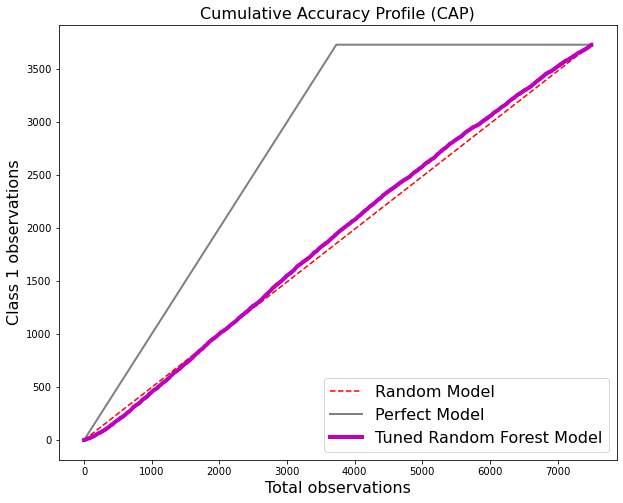

In [38]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
plt.figure(figsize = (10, 8))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_uni_tuned.predict_proba(test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned Random Forest Model', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Class 1 observations', fontsize = 16)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [39]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Tuned Random Forest Model: {}".format(aR / aP))

Accuracy Rate for Tuned Random Forest Model: 0.041389977314910294


Percentage: 52.386%


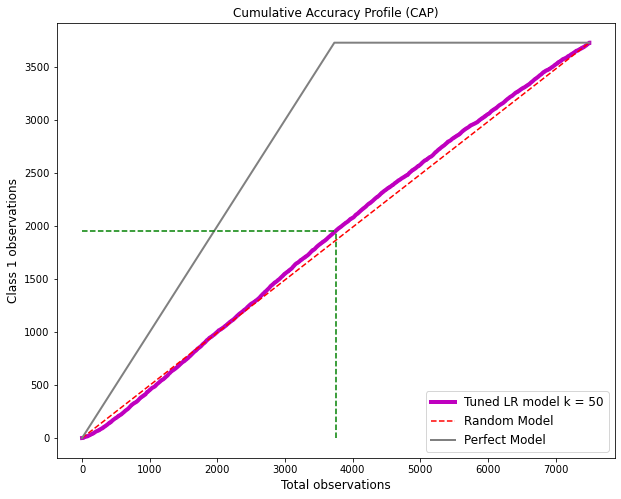

In [40]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR model k = 50', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

In [41]:
# Feature Selection with Univariate Statistical Tests with k = 500

test = SelectKBest(score_func=f_classif, k=500)
fit = test.fit(BOW_tv_train_features.toarray(), train_sentiments)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(BOW_tv_train_features.toarray());
# summarize selected features
print(features[0:500,:])

[0.108 0.027 0.995 ... 1.005 1.005 1.005]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [42]:
# fit.scores_ contains the score of all the features in the training set. In this code block we determine the column 
# number associated to the top k features obtained from the univariate feature selection test

# Save the scores to a variable named score and set the number of features desired (k)
k = 500
score = fit.scores_

# Retrieve the indices associated to the k highest scoring 
indices = score.argsort()[::-1][:k]
# Convert the test features from a sparse matrix to an array
test_features = BOW_tv_test_features.toarray()
# Retrieve the appropriate features from the testing dataset
test_features = test_features[:,indices]

In [43]:
# Define the tuned logistic regression model
lr_uni_tuned = LogisticRegression(penalty = 'l2',C = 100,class_weight={1: 0.7, 0: 0.3}, solver= 'liblinear', max_iter=1000)
lr_uni_tuned.fit(features, train_sentiments)
# Predict y_test values
lr_uni_tuned_preds = lr_uni_tuned.predict(test_features) 

In [44]:
# Retrieve the metrics for the model
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_uni_tuned_preds, classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.5295
Precision: 0.5317
Recall: 0.5295
F1 Score: 0.5178

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.54      0.37      0.44      3730
           0       0.52      0.68      0.59      3770

    accuracy                           0.53      7500
   macro avg       0.53      0.53      0.52      7500
weighted avg       0.53      0.53      0.52      7500


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       1392  2338
        0       1191  2579


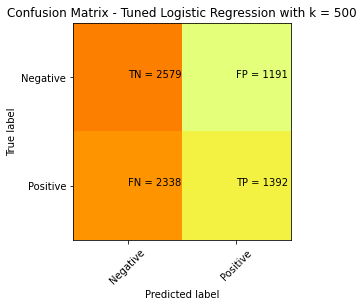

In [45]:
from sklearn.metrics import confusion_matrix,auc
import matplotlib.pyplot as plt

cm = confusion_matrix(test_sentiments, lr_uni_tuned_preds)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Tuned Logistic Regression with k = 500')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

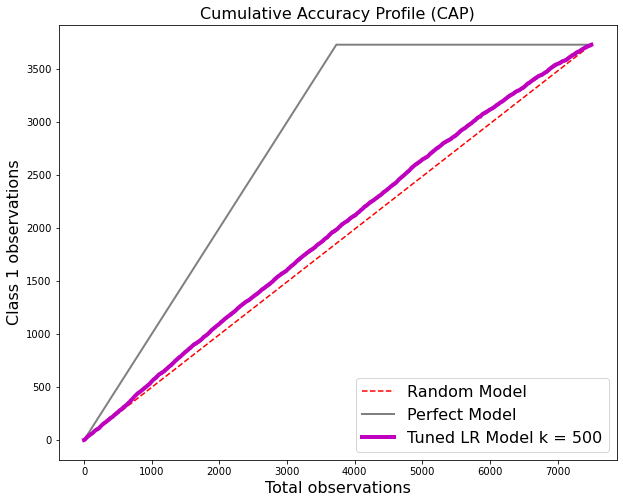

In [46]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
plt.figure(figsize = (10, 8))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_uni_tuned.predict_proba(test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR Model k = 500', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Class 1 observations', fontsize = 16)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [47]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Tuned Random Forest Model: {}".format(aR / aP))



Accuracy Rate for Tuned Random Forest Model: 0.1058604333634379


Percentage: 53.485%


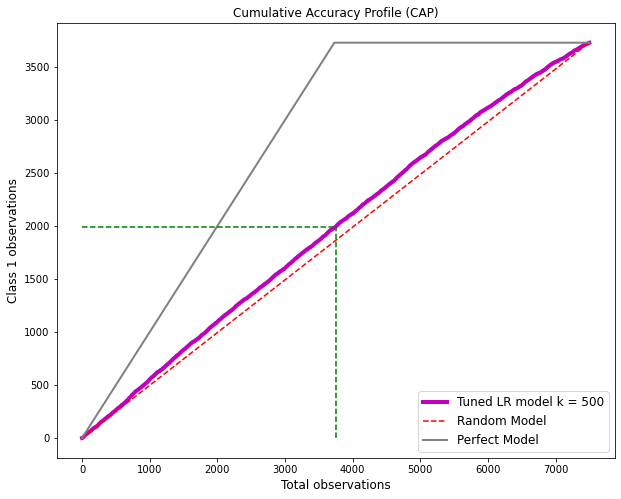

In [48]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR model k = 500', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

In [49]:
# Feature Selection with Univariate Statistical Tests with k = 5000

test = SelectKBest(score_func=f_classif, k=5000)
fit = test.fit(BOW_tv_train_features.toarray(), train_sentiments)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(BOW_tv_train_features.toarray());
# summarize selected features
print(features[0:5000,:])

[0.108 0.027 0.995 ... 1.005 1.005 1.005]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [50]:
# fit.scores_ contains the score of all the features in the training set. In this code block we determine the column 
# number associated to the top k features obtained from the univariate feature selection test

# Save the scores to a variable named score and set the number of features desired (k)
k = 5000
score = fit.scores_

# Retrieve the indices associated to the k highest scoring 
indices = score.argsort()[::-1][:k]
# Convert the test features from a sparse matrix to an array
test_features = BOW_tv_test_features.toarray()
# Retrieve the appropriate features from the testing dataset
test_features = test_features[:,indices]

In [51]:
# Define the tuned logistic regression model
lr_uni_tuned = LogisticRegression(penalty = 'l2',C = 100,class_weight={1: 0.7, 0: 0.3}, solver= 'liblinear', max_iter=1000)
lr_uni_tuned.fit(features, train_sentiments)
# Predict y_test values
lr_uni_tuned_preds = lr_uni_tuned.predict(test_features)

# Retrieve the metrics for the model
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_uni_tuned_preds, classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.4755
Precision: 0.4734
Recall: 0.4755
F1 Score: 0.4605

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.48      0.64      0.55      3730
           0       0.47      0.31      0.37      3770

    accuracy                           0.48      7500
   macro avg       0.47      0.48      0.46      7500
weighted avg       0.47      0.48      0.46      7500


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       2398  1332
        0       2602  1168


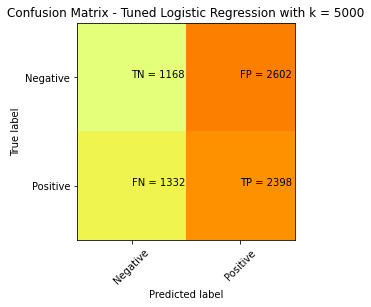

In [52]:
from sklearn.metrics import confusion_matrix,auc
import matplotlib.pyplot as plt

cm = confusion_matrix(test_sentiments, lr_uni_tuned_preds)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Tuned Logistic Regression with k = 5000')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

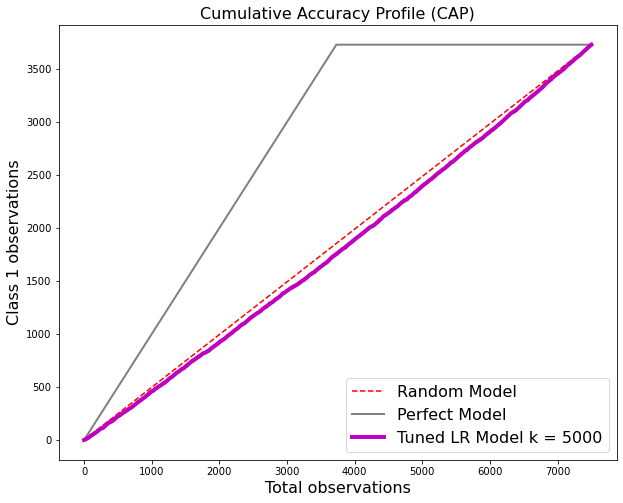

In [53]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
plt.figure(figsize = (10, 8))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_uni_tuned.predict_proba(test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR Model k = 5000', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Class 1 observations', fontsize = 16)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [54]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Tuned Random Forest Model: {}".format(aR / aP))


Accuracy Rate for Tuned Random Forest Model: -0.07111071603814509


Percentage: 47.292%


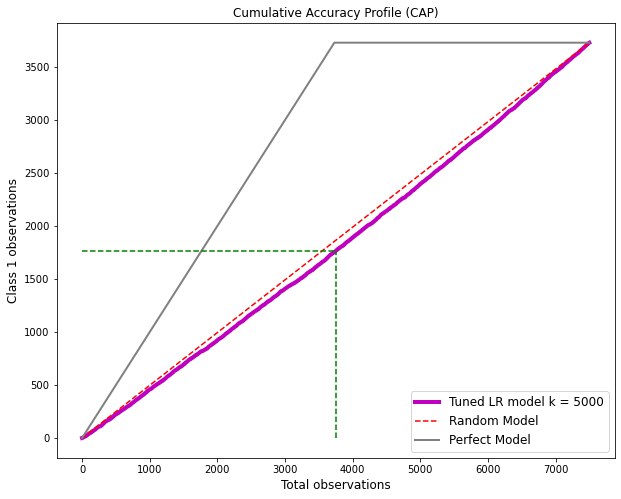

In [55]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR model k = 5000', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

In [56]:
# Feature Selection with Univariate Statistical Tests with k = 10000

test = SelectKBest(score_func=f_classif, k=10000)
fit = test.fit(BOW_tv_train_features.toarray(), train_sentiments)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(BOW_tv_train_features.toarray());
# summarize selected features
print(features[0:10000,:])

[0.108 0.027 0.995 ... 1.005 1.005 1.005]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [57]:
#fit.scores_ contains the score of all the features in the training set. In this code block we determine the column 
# number associated to the top k features obtained from the univariate feature selection test

# Save the scores to a variable named score and set the number of features desired (k)
k = 10000
score = fit.scores_

# Retrieve the indices associated to the k highest scoring 
indices = score.argsort()[::-1][:k]
# Convert the test features from a sparse matrix to an array
test_features = BOW_tv_test_features.toarray()
# Retrieve the appropriate features from the testing dataset
test_features = test_features[:,indices]

In [58]:
#Define the tuned logistic regression model
lr_uni_tuned = LogisticRegression(penalty = 'l2',C = 100,class_weight={1: 0.7, 0: 0.3}, solver= 'liblinear', max_iter=1000)
lr_uni_tuned.fit(features, train_sentiments)
# Predict y_test values
lr_uni_tuned_preds = lr_uni_tuned.predict(test_features)

# Retrieve the metrics for the model
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_uni_tuned_preds, classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.5139
Precision: 0.5145
Recall: 0.5139
F1 Score: 0.5118

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.51      0.58      0.54      3730
           0       0.52      0.45      0.48      3770

    accuracy                           0.51      7500
   macro avg       0.51      0.51      0.51      7500
weighted avg       0.51      0.51      0.51      7500


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       2164  1566
        0       2080  1690


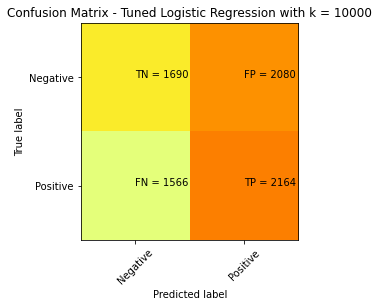

In [59]:
from sklearn.metrics import confusion_matrix,auc
import matplotlib.pyplot as plt

cm = confusion_matrix(test_sentiments, lr_uni_tuned_preds)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Tuned Logistic Regression with k = 10000')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

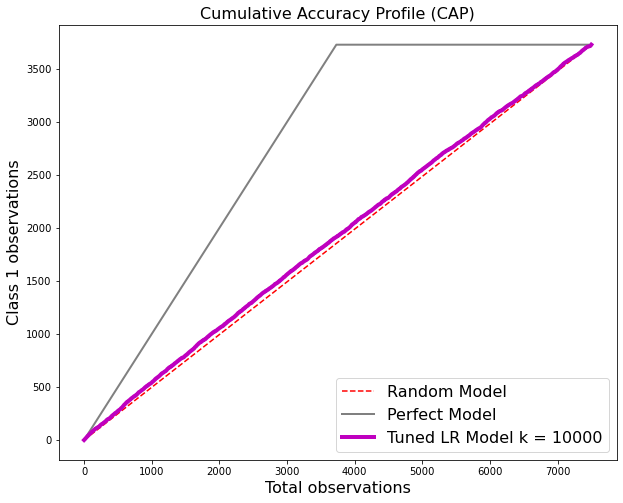

In [60]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
plt.figure(figsize = (10, 8))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_uni_tuned.predict_proba(test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR Model k = 10000', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Class 1 observations', fontsize = 16)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [61]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Tuned Random Forest Model: {}".format(aR / aP))


Accuracy Rate for Tuned Random Forest Model: 0.051400288719323575


Percentage: 51.609%


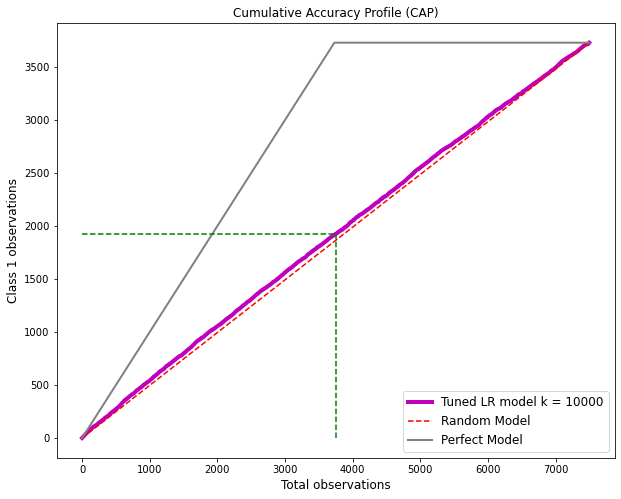

In [62]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR model k = 10000', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

In [63]:
# Feature Selection with Univariate Statistical Tests with k = 15000

test = SelectKBest(score_func=f_classif, k=15000)
fit = test.fit(BOW_tv_train_features.toarray(), train_sentiments)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(BOW_tv_train_features.toarray());
# summarize selected features
print(features[0:15000,:])

[0.108 0.027 0.995 ... 1.005 1.005 1.005]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [64]:
#fit.scores_ contains the score of all the features in the training set. In this code block we determine the column 
# number associated to the top k features obtained from the univariate feature selection test

# Save the scores to a variable named score and set the number of features desired (k)
k = 15000
score = fit.scores_

# Retrieve the indices associated to the k highest scoring 
indices = score.argsort()[::-1][:k]
# Convert the test features from a sparse matrix to an array
test_features = BOW_tv_test_features.toarray()
# Retrieve the appropriate features from the testing dataset
test_features = test_features[:,indices]

In [65]:
#Define the tuned logistic regression model
lr_uni_tuned = LogisticRegression(penalty = 'l2',C = 100,class_weight={1: 0.7, 0: 0.3}, solver= 'liblinear', max_iter=1000)
lr_uni_tuned.fit(features, train_sentiments)
# Predict y_test values
lr_uni_tuned_preds = lr_uni_tuned.predict(test_features)

# Retrieve the metrics for the model
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_uni_tuned_preds, classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.482
Precision: 0.4819
Recall: 0.482
F1 Score: 0.4819

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.48      0.47      0.47      3730
           0       0.49      0.50      0.49      3770

    accuracy                           0.48      7500
   macro avg       0.48      0.48      0.48      7500
weighted avg       0.48      0.48      0.48      7500


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       1746  1984
        0       1901  1869


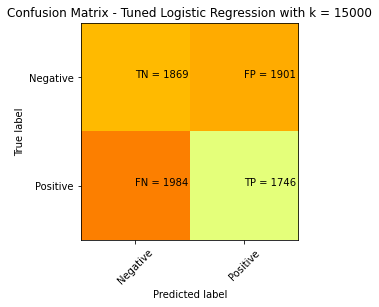

In [66]:
from sklearn.metrics import confusion_matrix,auc
import matplotlib.pyplot as plt

cm = confusion_matrix(test_sentiments, lr_uni_tuned_preds)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Tuned Logistic Regression with k = 15000')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

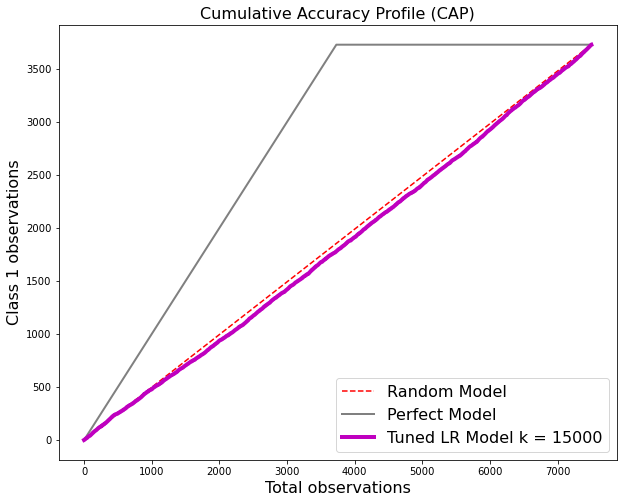

In [67]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
plt.figure(figsize = (10, 8))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_uni_tuned.predict_proba(test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR Model k = 15000', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Class 1 observations', fontsize = 16)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [68]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Tuned Random Forest Model: {}".format(aR / aP))


Accuracy Rate for Tuned Random Forest Model: -0.05338334957083224


Percentage: 48.070%


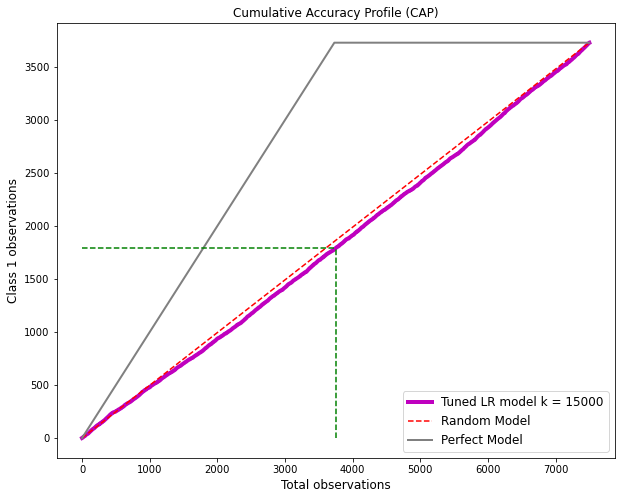

In [69]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR model k = 15000', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

## 5.2 Decision Tree Feature Importance<a class="anchor" id="6.3"></a>

In [70]:
# k = 5
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
#a = BOW_tv_train_features.toarray() #-> Keep for debugging purposes
#a = a[:,[1,2,3,4,5,6,7,8,9,10]] #-> Keep for debugging purposes
model = ExtraTreesClassifier(n_estimators=10)
model.fit(BOW_tv_train_features.toarray(), train_sentiments)
print(model.feature_importances_)

[0. 0. 0. ... 0. 0. 0.]


In [71]:
# fit.scores_ contains the score of all the features in the training set. In this code block we determine the column 
# number associated to the top k features obtained from the univariate feature selection test

# Save the scores to a variable named score and set the number of features desired (k)
k = 5 # -> Change to the desired number of features
importance = model.feature_importances_

# Retrieve the indices associated to the k highest scoring 
indices = importance.argsort()[::-1][:k]
# Convert the test features from a sparse matrix to an array
test_features = BOW_tv_test_features.toarray()
train_features = BOW_tv_train_features.toarray()
# Retrieve the appropriate features from the testing dataset
test_features = test_features[:,indices]
train_features = train_features[:,indices]

### Tuned Logistic Regression Revisited

In [72]:
# Define the tuned logistic regression model
lr_DT_tuned = LogisticRegression(penalty = 'l2',C = 100,class_weight={1: 0.7, 0: 0.3}, solver= 'liblinear', max_iter=1000)
lr_DT_tuned.fit(train_features,train_sentiments)
# Predict y_test values
lr_DT_tuned_preds = lr_DT_tuned.predict(test_features) 

In [73]:
# Retrieve the metrics for the model
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_DT_tuned_preds , classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.6775
Precision: 0.749
Recall: 0.6775
F1 Score: 0.6533

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.61      0.94      0.74      3730
           0       0.88      0.41      0.56      3770

    accuracy                           0.68      7500
   macro avg       0.75      0.68      0.65      7500
weighted avg       0.75      0.68      0.65      7500


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       3522   208
        0       2211  1559


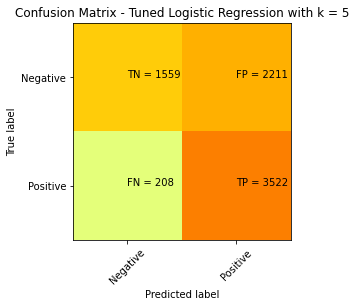

In [74]:
from sklearn.metrics import confusion_matrix,auc
import matplotlib.pyplot as plt

cm = confusion_matrix(test_sentiments, lr_DT_tuned_preds)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Tuned Logistic Regression with k = 5')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

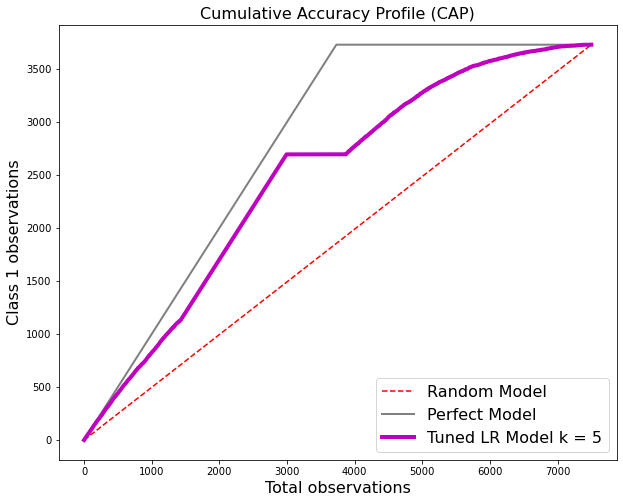

In [75]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
plt.figure(figsize = (10, 8))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_DT_tuned.predict_proba(test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR Model k = 5', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Class 1 observations', fontsize = 16)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [76]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Tuned Random Forest Model: {}".format(aR / aP))

Accuracy Rate for Tuned Random Forest Model: 0.6502017479608309


Percentage: 72.252%


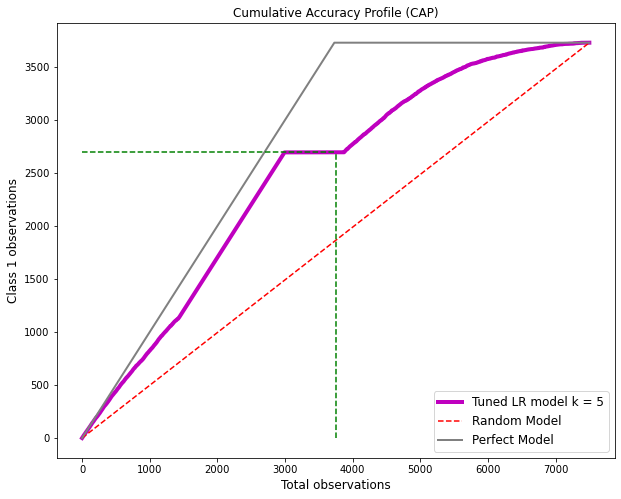

In [77]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR model k = 5', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

In [78]:
# k = 50 

from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
#a = BOW_tv_train_features.toarray() #-> Keep for debugging purposes
#a = a[:,[1,2,3,4,5,6,7,8,9,10]] #-> Keep for debugging purposes
model = ExtraTreesClassifier(n_estimators=10)
model.fit(BOW_tv_train_features.toarray(), train_sentiments)
print(model.feature_importances_)

# fit.scores_ contains the score of all the features in the training set. In this code block we determine the column 
# number associated to the top k features obtained from the univariate feature selection test

# Save the scores to a variable named score and set the number of features desired (k)
k = 50 # -> Change to the desired number of features
importance = model.feature_importances_

# Retrieve the indices associated to the k highest scoring 
indices = importance.argsort()[::-1][:k]
# Convert the test features from a sparse matrix to an array
test_features = BOW_tv_test_features.toarray()
train_features = BOW_tv_train_features.toarray()
# Retrieve the appropriate features from the testing dataset
test_features = test_features[:,indices]
train_features = train_features[:,indices]



[0.000e+00 0.000e+00 1.347e-05 ... 0.000e+00 1.310e-05 1.407e-07]


In [79]:
# Define the tuned logistic regression model
lr_DT_tuned = LogisticRegression(penalty = 'l2',C = 100,class_weight={1: 0.7, 0: 0.3}, solver= 'liblinear', max_iter=1000)
lr_DT_tuned.fit(train_features,train_sentiments)
# Predict y_test values
lr_DT_tuned_preds = lr_DT_tuned.predict(test_features)

In [80]:
# Retrieve the metrics for the model
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_DT_tuned_preds , classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.7867
Precision: 0.8153
Recall: 0.7867
F1 Score: 0.7819

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.72      0.94      0.81      3730
           0       0.91      0.64      0.75      3770

    accuracy                           0.79      7500
   macro avg       0.81      0.79      0.78      7500
weighted avg       0.82      0.79      0.78      7500


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       3493   237
        0       1363  2407


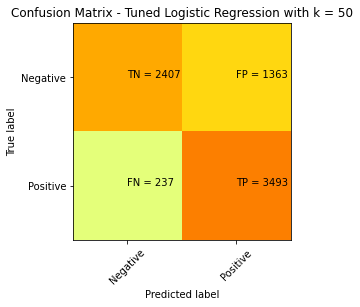

In [81]:
from sklearn.metrics import confusion_matrix,auc
import matplotlib.pyplot as plt

cm = confusion_matrix(test_sentiments, lr_DT_tuned_preds)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Tuned Logistic Regression with k = 50')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

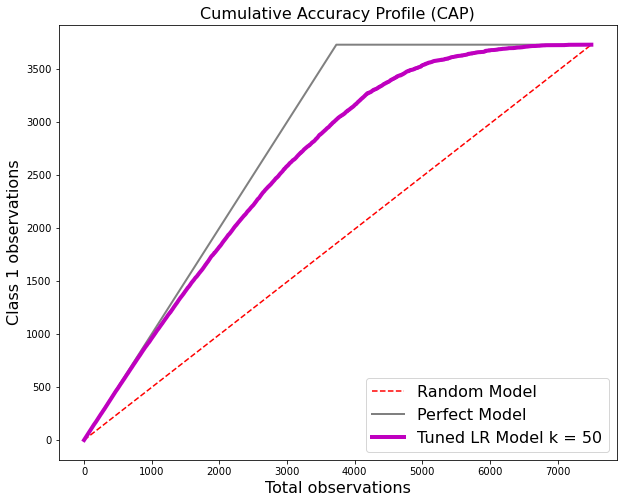

In [82]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
plt.figure(figsize = (10, 8))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_DT_tuned.predict_proba(test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR Model k = 50', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Class 1 observations', fontsize = 16)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [83]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Tuned Random Forest Model: {}".format(aR / aP))

Accuracy Rate for Tuned Random Forest Model: 0.7899515719558245


Percentage: 81.394%


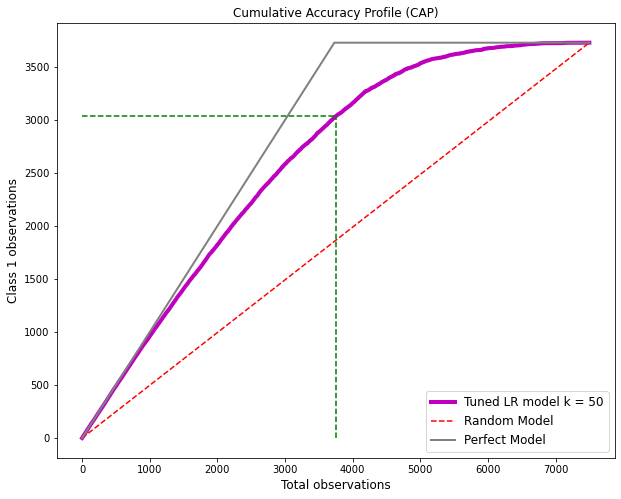

In [84]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR model k = 50', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

In [85]:
# k = 500

from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
#a = BOW_tv_train_features.toarray() #-> Keep for debugging purposes
#a = a[:,[1,2,3,4,5,6,7,8,9,10]] #-> Keep for debugging purposes
model = ExtraTreesClassifier(n_estimators=10)
model.fit(BOW_tv_train_features.toarray(), train_sentiments)
print(model.feature_importances_)

# fit.scores_ contains the score of all the features in the training set. In this code block we determine the column 
# number associated to the top k features obtained from the univariate feature selection test

# Save the scores to a variable named score and set the number of features desired (k)
k = 500 # -> Change to the desired number of features
importance = model.feature_importances_

# Retrieve the indices associated to the k highest scoring 
indices = importance.argsort()[::-1][:k]
# Convert the test features from a sparse matrix to an array
test_features = BOW_tv_test_features.toarray()
train_features = BOW_tv_train_features.toarray()
# Retrieve the appropriate features from the testing dataset
test_features = test_features[:,indices]
train_features = train_features[:,indices]



[0.00e+00 0.00e+00 0.00e+00 ... 2.54e-07 0.00e+00 0.00e+00]


In [86]:
# Define the tuned logistic regression model
lr_DT_tuned = LogisticRegression(penalty = 'l2',C = 100,class_weight={1: 0.7, 0: 0.3}, solver= 'liblinear', max_iter=1000)
lr_DT_tuned.fit(train_features,train_sentiments)
# Predict y_test values
lr_DT_tuned_preds = lr_DT_tuned.predict(test_features)

In [87]:
# Retrieve the metrics for the model
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_DT_tuned_preds , classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.8493
Precision: 0.8608
Recall: 0.8493
F1 Score: 0.8482

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.80      0.94      0.86      3730
           0       0.93      0.76      0.84      3770

    accuracy                           0.85      7500
   macro avg       0.86      0.85      0.85      7500
weighted avg       0.86      0.85      0.85      7500


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       3498   232
        0        898  2872


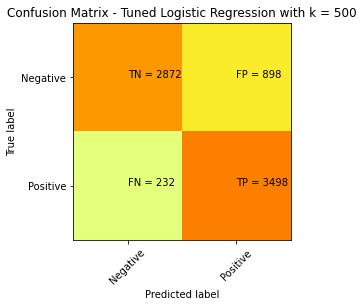

In [88]:
from sklearn.metrics import confusion_matrix,auc
import matplotlib.pyplot as plt

cm = confusion_matrix(test_sentiments, lr_DT_tuned_preds)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Tuned Logistic Regression with k = 500')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

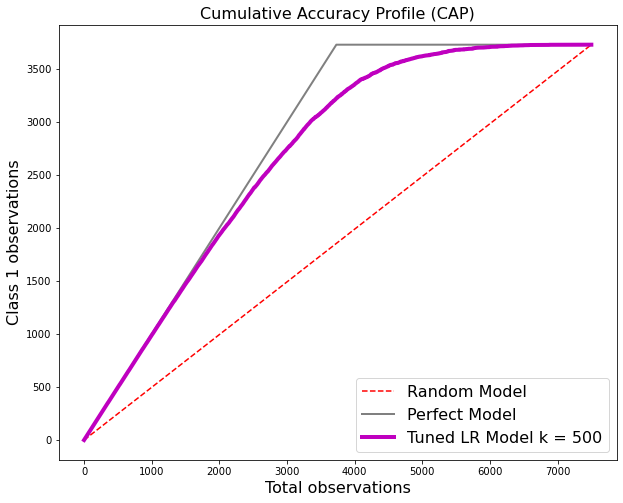

In [89]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
plt.figure(figsize = (10, 8))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_DT_tuned.predict_proba(test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR Model k = 500', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Class 1 observations', fontsize = 16)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [90]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Tuned Random Forest Model: {}".format(aR / aP))

Accuracy Rate for Tuned Random Forest Model: 0.8791173437822232


Percentage: 86.702%


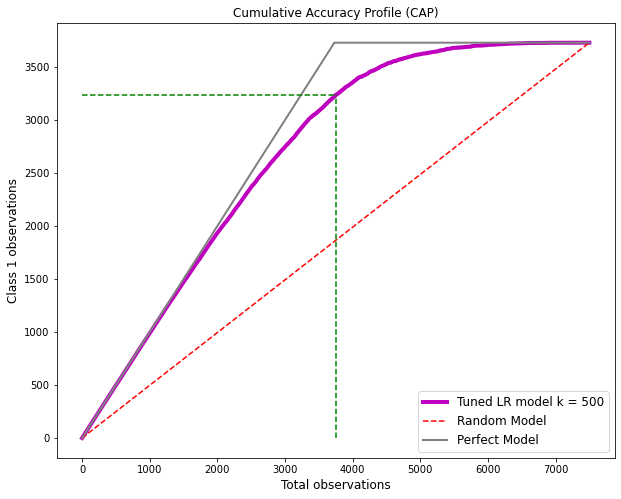

In [91]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR model k = 500', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

In [92]:
# k = 5000

from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
#a = BOW_tv_train_features.toarray() #-> Keep for debugging purposes
#a = a[:,[1,2,3,4,5,6,7,8,9,10]] #-> Keep for debugging purposes
model = ExtraTreesClassifier(n_estimators=10)
model.fit(BOW_tv_train_features.toarray(), train_sentiments)
print(model.feature_importances_)

# fit.scores_ contains the score of all the features in the training set. In this code block we determine the column 
# number associated to the top k features obtained from the univariate feature selection test

# Save the scores to a variable named score and set the number of features desired (k)
k = 5000 # -> Change to the desired number of features
importance = model.feature_importances_

# Retrieve the indices associated to the k highest scoring 
indices = importance.argsort()[::-1][:k]
# Convert the test features from a sparse matrix to an array
test_features = BOW_tv_test_features.toarray()
train_features = BOW_tv_train_features.toarray()
# Retrieve the appropriate features from the testing dataset
test_features = test_features[:,indices]
train_features = train_features[:,indices]



[0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 1.694e-05 7.563e-07]


In [93]:
# Define the tuned logistic regression model
lr_DT_tuned = LogisticRegression(penalty = 'l2',C = 100,class_weight={1: 0.7, 0: 0.3}, solver= 'liblinear', max_iter=1000)
lr_DT_tuned.fit(train_features,train_sentiments)
# Predict y_test values
lr_DT_tuned_preds = lr_DT_tuned.predict(test_features)
# Retrieve the metrics for the model
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_DT_tuned_preds , classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.856
Precision: 0.8586
Recall: 0.856
F1 Score: 0.8558

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.83      0.90      0.86      3730
           0       0.89      0.81      0.85      3770

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       3348   382
        0        698  3072


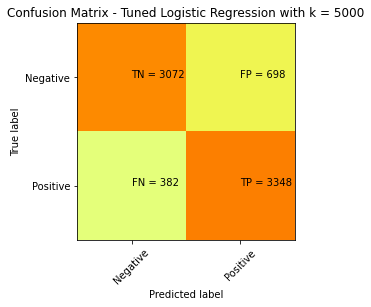

In [94]:
from sklearn.metrics import confusion_matrix,auc
import matplotlib.pyplot as plt

cm = confusion_matrix(test_sentiments, lr_DT_tuned_preds)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Tuned Logistic Regression with k = 5000')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

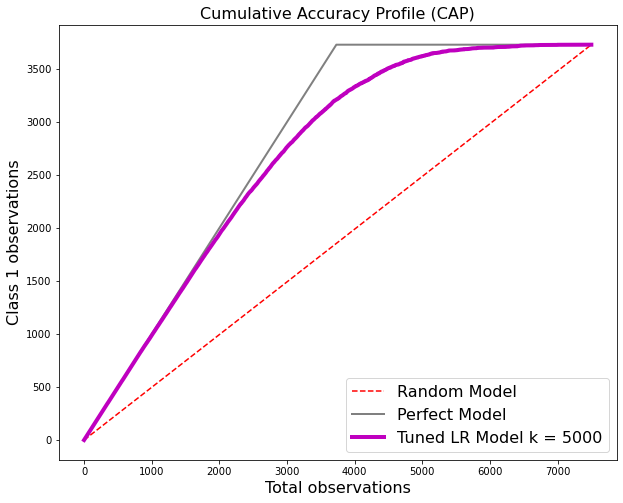

In [95]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
plt.figure(figsize = (10, 8))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_DT_tuned.predict_proba(test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR Model k = 5000', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Class 1 observations', fontsize = 16)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [96]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Tuned Random Forest Model: {}".format(aR / aP))

Accuracy Rate for Tuned Random Forest Model: 0.877833325036801


Percentage: 86.327%


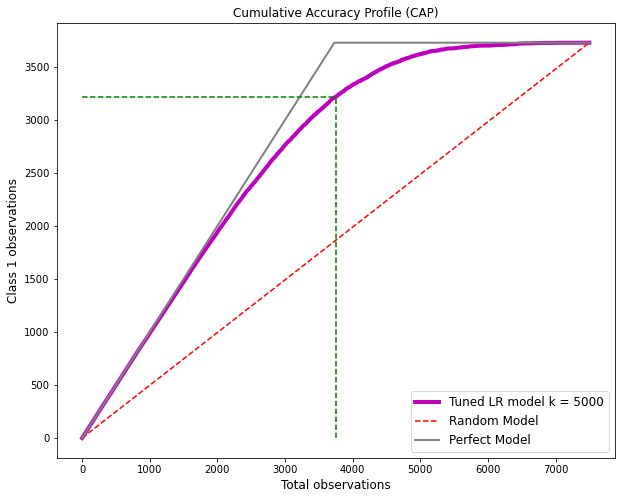

In [97]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR model k = 5000', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

In [98]:
# k = 10000

from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
#a = BOW_tv_train_features.toarray() #-> Keep for debugging purposes
#a = a[:,[1,2,3,4,5,6,7,8,9,10]] #-> Keep for debugging purposes
model = ExtraTreesClassifier(n_estimators=10)
model.fit(BOW_tv_train_features.toarray(), train_sentiments)
print(model.feature_importances_)

# fit.scores_ contains the score of all the features in the training set. In this code block we determine the column 
# number associated to the top k features obtained from the univariate feature selection test

# Save the scores to a variable named score and set the number of features desired (k)
k = 10000 # -> Change to the desired number of features
importance = model.feature_importances_

# Retrieve the indices associated to the k highest scoring 
indices = importance.argsort()[::-1][:k]
# Convert the test features from a sparse matrix to an array
test_features = BOW_tv_test_features.toarray()
train_features = BOW_tv_train_features.toarray()
# Retrieve the appropriate features from the testing dataset
test_features = test_features[:,indices]
train_features = train_features[:,indices]


[0. 0. 0. ... 0. 0. 0.]


In [99]:
# Define the tuned logistic regression model
lr_DT_tuned = LogisticRegression(penalty = 'l2',C = 100,class_weight={1: 0.7, 0: 0.3}, solver= 'liblinear', max_iter=1000)
lr_DT_tuned.fit(train_features,train_sentiments)
# Predict y_test values
lr_DT_tuned_preds = lr_DT_tuned.predict(test_features)
# Retrieve the metrics for the model
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_DT_tuned_preds , classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.8641
Precision: 0.8661
Recall: 0.8641
F1 Score: 0.864

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.84      0.90      0.87      3730
           0       0.89      0.83      0.86      3770

    accuracy                           0.86      7500
   macro avg       0.87      0.86      0.86      7500
weighted avg       0.87      0.86      0.86      7500


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       3356   374
        0        645  3125


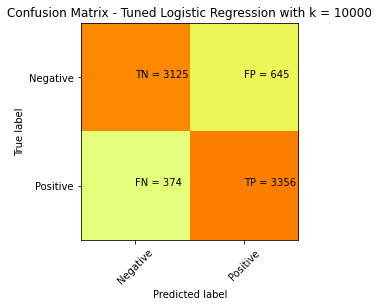

In [100]:
from sklearn.metrics import confusion_matrix,auc
import matplotlib.pyplot as plt

cm = confusion_matrix(test_sentiments, lr_DT_tuned_preds)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Tuned Logistic Regression with k = 10000')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

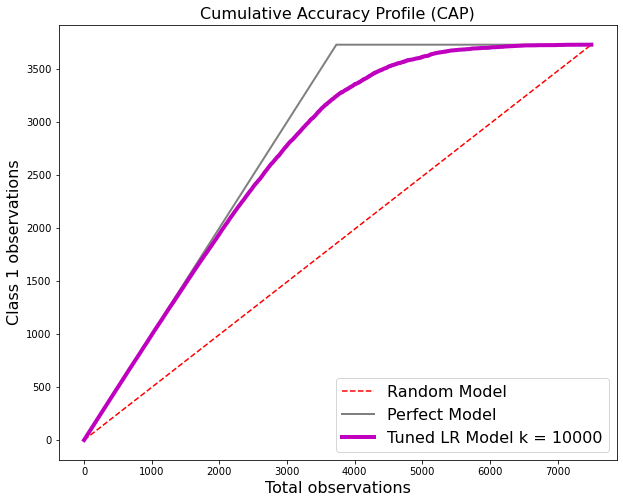

In [101]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
plt.figure(figsize = (10, 8))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_DT_tuned.predict_proba(test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR Model k = 10000', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Class 1 observations', fontsize = 16)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [102]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Tuned Random Forest Model: {}".format(aR / aP))

Accuracy Rate for Tuned Random Forest Model: 0.8849237311639087


Percentage: 87.265%


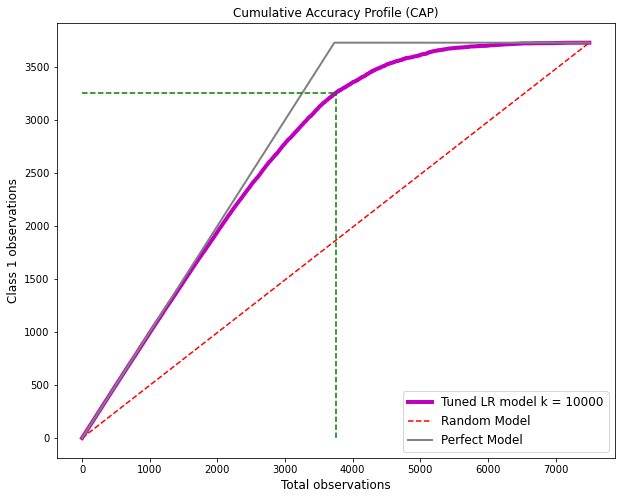

In [103]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR model k = 10000', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

In [104]:
# k = 15000

from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
#a = BOW_tv_train_features.toarray() #-> Keep for debugging purposes
#a = a[:,[1,2,3,4,5,6,7,8,9,10]] #-> Keep for debugging purposes
model = ExtraTreesClassifier(n_estimators=10)
model.fit(BOW_tv_train_features.toarray(), train_sentiments)
print(model.feature_importances_)

# fit.scores_ contains the score of all the features in the training set. In this code block we determine the column 
# number associated to the top k features obtained from the univariate feature selection test

# Save the scores to a variable named score and set the number of features desired (k)
k = 15000 # -> Change to the desired number of features
importance = model.feature_importances_

# Retrieve the indices associated to the k highest scoring 
indices = importance.argsort()[::-1][:k]
# Convert the test features from a sparse matrix to an array
test_features = BOW_tv_test_features.toarray()
train_features = BOW_tv_train_features.toarray()
# Retrieve the appropriate features from the testing dataset
test_features = test_features[:,indices]
train_features = train_features[:,indices]


[7.619e-06 0.000e+00 1.361e-05 ... 0.000e+00 0.000e+00 0.000e+00]


In [105]:
# Define the tuned logistic regression model
lr_DT_tuned = LogisticRegression(penalty = 'l2',C = 100,class_weight={1: 0.7, 0: 0.3}, solver= 'liblinear', max_iter=1000)
lr_DT_tuned.fit(train_features,train_sentiments)
# Predict y_test values
lr_DT_tuned_preds = lr_DT_tuned.predict(test_features)
# Retrieve the metrics for the model
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_DT_tuned_preds , classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.8663
Precision: 0.868
Recall: 0.8663
F1 Score: 0.8661

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.84      0.90      0.87      3730
           0       0.89      0.83      0.86      3770

    accuracy                           0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.87      0.87      0.87      7500


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       3356   374
        0        629  3141


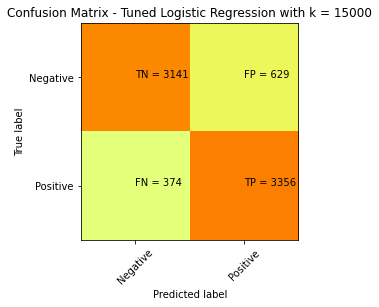

In [106]:
from sklearn.metrics import confusion_matrix,auc
import matplotlib.pyplot as plt

cm = confusion_matrix(test_sentiments, lr_DT_tuned_preds)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Tuned Logistic Regression with k = 15000')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

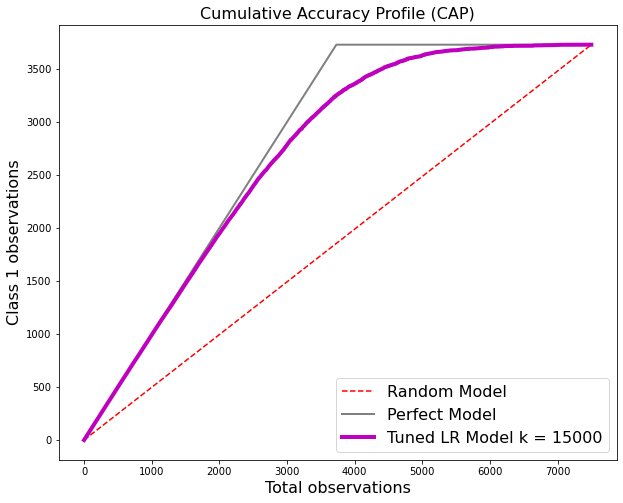

In [107]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
plt.figure(figsize = (10, 8))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_DT_tuned.predict_proba(test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR Model k = 15000', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Class 1 observations', fontsize = 16)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [108]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Tuned Random Forest Model: {}".format(aR / aP))

Accuracy Rate for Tuned Random Forest Model: 0.8888766258240235


Percentage: 87.453%


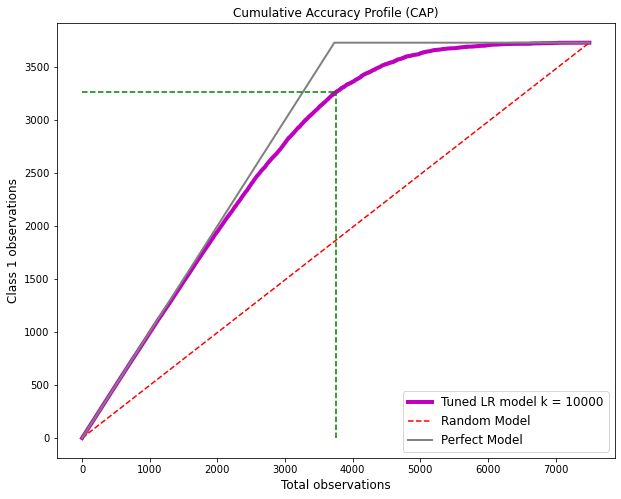

In [109]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR model k = 10000', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

In [110]:
# k = 20000

from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
#a = BOW_tv_train_features.toarray() #-> Keep for debugging purposes
#a = a[:,[1,2,3,4,5,6,7,8,9,10]] #-> Keep for debugging purposes
model = ExtraTreesClassifier(n_estimators=10)
model.fit(BOW_tv_train_features.toarray(), train_sentiments)
print(model.feature_importances_)

# fit.scores_ contains the score of all the features in the training set. In this code block we determine the column 
# number associated to the top k features obtained from the univariate feature selection test

# Save the scores to a variable named score and set the number of features desired (k)
k = 20000 # -> Change to the desired number of features
importance = model.feature_importances_

# Retrieve the indices associated to the k highest scoring 
indices = importance.argsort()[::-1][:k]
# Convert the test features from a sparse matrix to an array
test_features = BOW_tv_test_features.toarray()
train_features = BOW_tv_train_features.toarray()
# Retrieve the appropriate features from the testing dataset
test_features = test_features[:,indices]
train_features = train_features[:,indices]


[4.082e-07 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]


In [111]:
# Define the tuned logistic regression model
lr_DT_tuned = LogisticRegression(penalty = 'l2',C = 100,class_weight={1: 0.7, 0: 0.3}, solver= 'liblinear', max_iter=1000)
lr_DT_tuned.fit(train_features,train_sentiments)
# Predict y_test values
lr_DT_tuned_preds = lr_DT_tuned.predict(test_features)
# Retrieve the metrics for the model
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_DT_tuned_preds , classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.8695
Precision: 0.871
Recall: 0.8695
F1 Score: 0.8694

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.85      0.90      0.87      3730
           0       0.90      0.84      0.87      3770

    accuracy                           0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.87      0.87      0.87      7500


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       3360   370
        0        609  3161


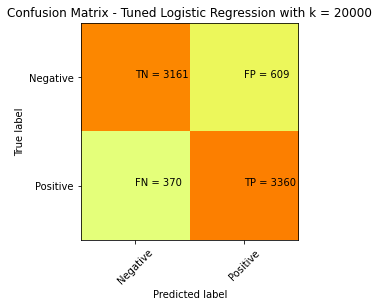

In [112]:
from sklearn.metrics import confusion_matrix,auc
import matplotlib.pyplot as plt

cm = confusion_matrix(test_sentiments, lr_DT_tuned_preds)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Tuned Logistic Regression with k = 20000')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

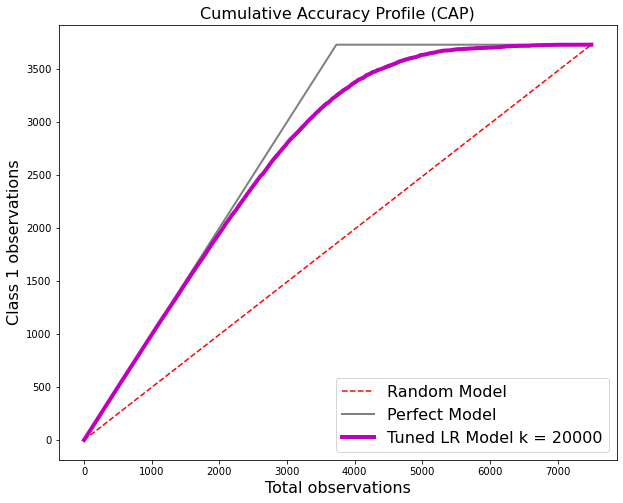

In [113]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
plt.figure(figsize = (10, 8))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_DT_tuned.predict_proba(test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR Model k = 20000', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Class 1 observations', fontsize = 16)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [114]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Tuned Random Forest Model: {}".format(aR / aP))

Accuracy Rate for Tuned Random Forest Model: 0.8915698224305046


Percentage: 87.319%


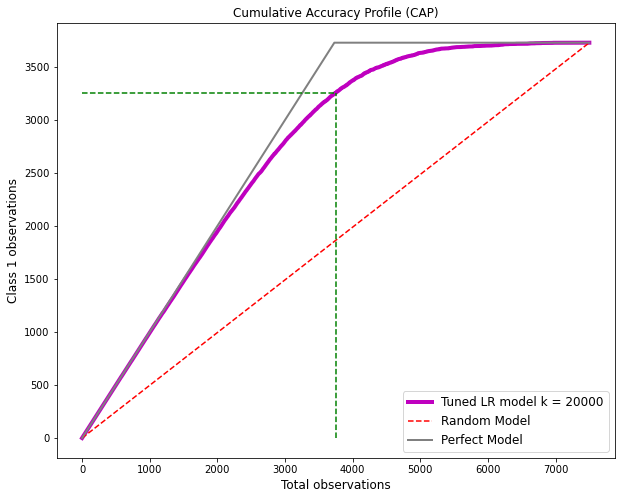

In [115]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR model k = 20000', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

# 5.3 PCA

In [116]:
# Feature Extraction with PCA

from sklearn.decomposition import PCA

# Convert the datasets from sparse matrix to array
test_features = BOW_tv_test_features.toarray()
train_features = BOW_tv_train_features.toarray()

# feature extraction
pca = PCA(n_components=3000)
fit = pca.fit(train_features)

# summarize components
print("Explained Variance: %s" % fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance: [4.331e-03 2.980e-03 2.509e-03 ... 7.117e-05 7.095e-05 7.081e-05]
[[-1.234e-04 -1.765e-04 -2.085e-06 ...  1.603e-05 -2.220e-04  2.839e-05]
 [-8.468e-05 -2.292e-04  1.510e-04 ... -3.456e-05 -8.351e-04  2.826e-04]
 [ 3.882e-04  3.946e-07 -1.593e-04 ... -2.440e-04  2.158e-04 -5.080e-04]
 ...
 [-1.336e-03 -3.155e-04  4.921e-04 ... -1.945e-03  4.311e-03 -1.455e-03]
 [-9.337e-04 -3.161e-03  8.862e-05 ...  1.735e-03 -2.842e-04 -1.511e-03]
 [-4.875e-04 -2.978e-03 -7.955e-04 ...  1.698e-04 -1.703e-03  6.916e-04]]


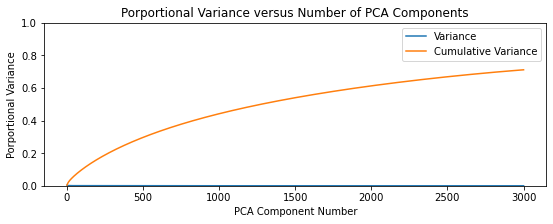

In [117]:
# This block of code is used to determine the number of components that are needed to represent the model
# set the value of the x axis
x_axis = []
ctr = 1
for i in range(0,3000):
    x_axis.append(ctr);
    ctr = ctr+1

plt.figure(figsize=(9, 3))
line1, = plt.plot(x_axis, pca.explained_variance_ratio_, '-',label='Variance')
line2, = plt.plot(x_axis,pca.explained_variance_ratio_.cumsum(), '-',label='Cumulative Variance')
plt.title("Porportional Variance versus Number of PCA Components")
plt.xlabel("PCA Component Number")
plt.ylabel("Porportional Variance")
plt.ylim([0,1])
plt.legend(handles=[line1, line2])

In [118]:
# Use PCA features in the model
train_pca = pca.transform(train_features)
test_pca = pca.transform(test_features)

### Tuned Logistic Regression Revisited

In [119]:
# Define the tuned logistic regression model
lr_PCA_tuned = LogisticRegression(penalty = 'l2',C = 100,class_weight={1: 0.7, 0: 0.3}, solver= 'liblinear', max_iter=1000)
lr_PCA_tuned.fit(train_pca,train_sentiments)
# Predict y_test values
lr_PCA_tuned_preds = lr_PCA_tuned.predict(test_pca) 

In [120]:
# Retrieve the metrics for the model
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_PCA_tuned_preds , classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.8677
Precision: 0.8712
Recall: 0.8677
F1 Score: 0.8675

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.83      0.92      0.87      3730
           0       0.91      0.82      0.86      3770

    accuracy                           0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.87      0.87      0.87      7500


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       3413   317
        0        675  3095


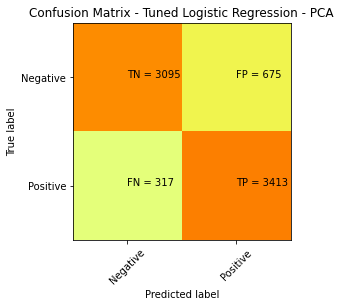

In [121]:
from sklearn.metrics import confusion_matrix,auc
import matplotlib.pyplot as plt

cm = confusion_matrix(test_sentiments, lr_PCA_tuned_preds)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Tuned Logistic Regression - PCA')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

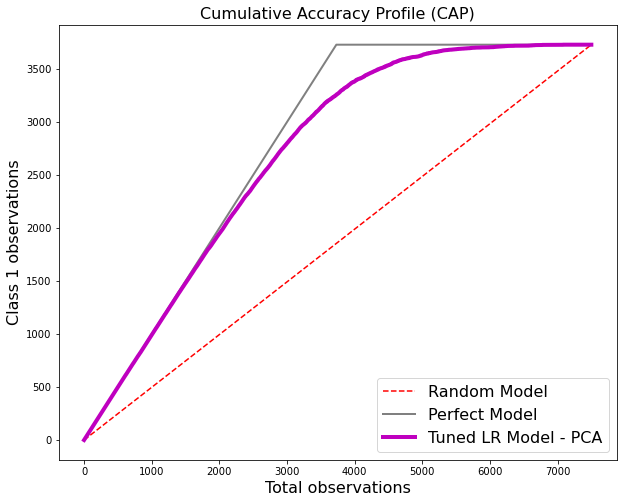

In [122]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
plt.figure(figsize = (10, 8))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_PCA_tuned.predict_proba(test_pca)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR Model - PCA', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Class 1 observations', fontsize = 16)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [123]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Tuned Random Forest Model: {}".format(aR / aP))

Accuracy Rate for Tuned Random Forest Model: 0.8948235327582651


Percentage: 87.587%


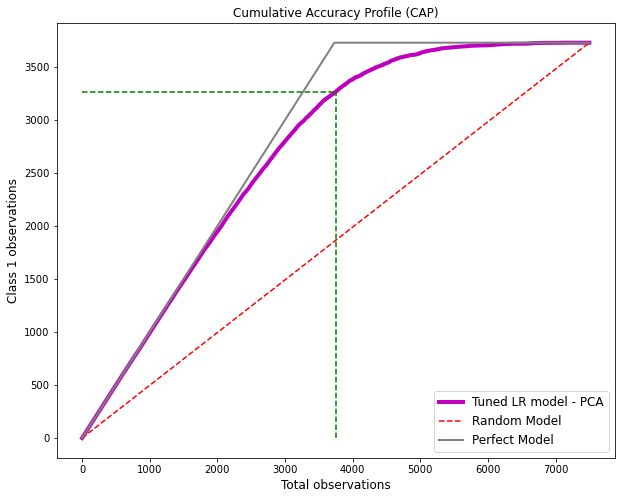

In [124]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned LR model - PCA', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))